In [1]:
import numpy as np
import os
import glob
import torch
import torch.nn as nn
import rasterio
import random
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Preprocessing

In [3]:
ROOT_DIR = r"D:\OneDrive - Computer and Information Technology (Menofia University)\Desktop\test\EuroSAT_MS"
NUM_CLASSES = 10
BATCH_SIZE = 32
NUM_EPOCHS = 1

RESIZE_TO = (96, 96)

def manual_resize(image: torch.Tensor, new_height: int, new_width: int) -> torch.Tensor:
    dtype = image.dtype
    device = image.device
    image = image.unsqueeze(0).to(dtype=dtype, device=device)
    resized = F.interpolate(image, size=(new_height, new_width), mode='bilinear', align_corners=False)
    return resized.squeeze(0)


class EuroSATMSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = []
        self.labels = []
        self.transform = transform

        classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        self._load_samples(root_dir, classes)

    def _load_samples(self, root_dir, classes):
        for cls_name in classes:
            cls_idx = self.class_to_idx[cls_name]
            cls_folder = os.path.join(root_dir, cls_name)
            img_paths = glob.glob(os.path.join(cls_folder, "*.tif"))
            self.paths.extend(img_paths)
            self.labels.extend([cls_idx] * len(img_paths))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]

        with rasterio.open(img_path) as src:
            image_np = src.read()         

        image_tensor = torch.from_numpy(image_np).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label



MS_MEAN = torch.tensor([
    1353.7289, 1117.2061, 1041.8864, 946.5517, 1199.1844, 2003.0060,
    2374.0132, 2301.2263, 732.1810, 12.0996, 1820.6929, 1118.2050,
    2599.7854
])

MS_STD = torch.tensor([
    245.2682, 333.4232, 395.2124, 594.4780, 567.0257, 861.0189,
    1086.9409, 1118.3157, 403.8531, 4.7293, 1002.5690, 760.5990,
    1231.6958
])



class MultiSpectralTrainTransformAdvanced:
    def __init__(self, mean, std, resize_to, crop_scale=(1.0, 2.0)):
        self.mean = mean
        self.std = std
        self.resize_to = resize_to
        self.crop_scale = crop_scale

    def __call__(self, img):
        if random.random() < 0.5:
            img = torch.flip(img, dims=[2])
        if random.random() < 0.5:
            img = torch.flip(img, dims=[1])

        k = random.choice([0,1,2,3])
        img = torch.rot90(img, k, dims=[1,2])

        C, H, W = img.shape
        scale = random.uniform(*self.crop_scale)
        new_H, new_W = int(H * scale), int(W * scale)
        img = manual_resize(img, new_H, new_W)

        top = random.randint(0, max(0, new_H - self.resize_to[0]))
        left = random.randint(0, max(0, new_W - self.resize_to[1]))
        img = img[:, top:top + self.resize_to[0], left:left + self.resize_to[1]]

        img = manual_resize(img, self.resize_to[0], self.resize_to[1])

        img = (img - self.mean[:, None, None]) / self.std[:, None, None]

        return img


# Test Transform
class MultiSpectralTestTransform:
    def __init__(self, mean, std, resize_to):
        self.mean = mean
        self.std = std
        self.resize_to = resize_to

    def __call__(self, img):
        img = manual_resize(img, self.resize_to[0], self.resize_to[1])
        img = (img - self.mean[:, None, None]) / self.std[:, None, None]
        return img



class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


def load_and_split_eurosat(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

    if not np.isclose(train_ratio + val_ratio + test_ratio, 1.0):
        raise ValueError("Ratios must sum to 1.0")

    train_transform = MultiSpectralTrainTransformAdvanced(MS_MEAN, MS_STD, RESIZE_TO)
    test_transform  = MultiSpectralTestTransform(MS_MEAN, MS_STD, RESIZE_TO)

    full_dataset = EuroSATMSDataset(root_dir, transform=None)

    total = len(full_dataset)
    train_size = int(train_ratio * total)
    val_size   = int(val_ratio * total)
    test_size  = total - train_size - val_size

    train_subset, val_subset, test_subset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_dataset = SubsetWithTransform(train_subset, transform=train_transform)
    val_dataset   = SubsetWithTransform(val_subset,   transform=test_transform)
    test_dataset  = SubsetWithTransform(test_subset,  transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = load_and_split_eurosat(ROOT_DIR)

# Models

In [4]:
class EurosatNet(nn.Module):
    def __init__(self, num_classes=10):
        super(EurosatNet, self).__init__()
        self.conv1 = nn.Conv2d(13, 32, kernel_size=3, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool(x)

        x = self.adaptive_pool(x)            
        x = torch.flatten(x, 1)             

        x = self.relu1(self.fc1(x))
        x = self.dropout(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [5]:
import torch
import torch.nn as nn

class EurosatNet2(nn.Module):
    
    def __init__(self):
        super(EurosatNet2, self).__init__()
        
        self.conv1 = nn.Conv2d(13, 32, kernel_size=7, stride=1, padding=3)
        self.relu_conv1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3)
        self.relu_conv2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=3)
        self.relu_conv3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        
        self.linear1 = nn.Linear(128*8*8, 2048)
        self.relu_fc1 = nn.ReLU(inplace=True)
        
        self.linear2 = nn.Linear(2048, 2048)
        self.relu_fc2 = nn.ReLU(inplace=True)
        
        self.linear3 = nn.Linear(2048, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.pool1(self.relu_conv1(self.conv1(x)))
        x = self.pool2(self.relu_conv2(self.conv2(x)))
        x = self.pool3(self.relu_conv3(self.conv3(x)))
        
        x = self.adaptive_pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.relu_fc1(self.linear1(x))
        x = self.relu_fc2(self.linear2(x))
        x = self.logsoftmax(self.linear3(x))
        
        return x

In [6]:
def modify_resnet50_for_eurosat(num_classes=10):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    old_conv1_weights = model.conv1.weight.data
    
    new_conv1 = nn.Conv2d(
        in_channels=13, 
        out_channels=model.conv1.out_channels, 
        kernel_size=model.conv1.kernel_size, 
        stride=model.conv1.stride, 
        padding=model.conv1.padding, 
        bias=model.conv1.bias
    )

    mean_weights = old_conv1_weights.mean(dim=1, keepdim=True) 
    new_weights = mean_weights.repeat(1, 13, 1, 1) 
    
    new_conv1.weight.data = new_weights
    
    model.conv1 = new_conv1

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

In [7]:
model_google_net = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
model_google_net = model_google_net.to(device)
model_google_net.eval()

NUM_CHANNELS = 13
NUM_CLASSES = 10

def get_modified_googlenet(num_input_channels=NUM_CHANNELS, num_output_classes=NUM_CLASSES, pretrained=True):
    
    print(f"Loading GoogLeNet (Pretrained={pretrained})...")

    model = models.googlenet(pretrained=pretrained, aux_logits=True, transform_input=False) 

    original_conv1_module = model.conv1
    original_conv1 = original_conv1_module.conv
    
    new_conv = nn.Conv2d(
        in_channels=num_input_channels, 
        out_channels=original_conv1.out_channels, 
        kernel_size=original_conv1.kernel_size, 
        stride=original_conv1.stride, 
        padding=original_conv1.padding, 
        bias=original_conv1.bias
    )
    original_conv1_module.conv = new_conv
    nn.init.kaiming_normal_(original_conv1_module.conv.weight, mode='fan_out', nonlinearity='relu')

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_output_classes)

    model.aux_logits = False
    model.aux1 = None
    model.aux2 = None
    
    print(f"Model adapted: Input set to {num_input_channels} channels. Output set to {num_output_classes} classes.")
    return model

In [8]:

def init_weights_kaiming(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if getattr(m, 'bias', None) is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [9]:
class PrependResNet50(nn.Module):
    def __init__(self, num_classes=10, n_pre_convs=1, deep_head_dims=[1024,512], p_dropout=0.4, pretrained=True):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        self.base = base

        old_conv = self.base.conv1
        self.base.conv1 = nn.Conv2d(64, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                                    stride=old_conv.stride, padding=old_conv.padding, bias=False)

        layers = []
        in_ch = 13
        out_ch = 64
        for i in range(n_pre_convs):
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.ReLU(inplace=True))
            in_ch = out_ch
        self.prepend = nn.Sequential(*layers)

        self.prepend.apply(init_weights_kaiming)

        try:
            old_w = old_conv.weight.data
            pass
        except Exception:
            pass

        in_feat = self.base.fc.in_features
        head_layers = []
        last = in_feat
        for h in deep_head_dims:
            head_layers += [ nn.Linear(last, h), nn.BatchNorm1d(h), nn.ReLU(inplace=True), nn.Dropout(p_dropout) ]
            last = h
        head_layers += [ nn.Linear(last, num_classes) ]
        self.base.fc = nn.Sequential(*head_layers)
        self.base.fc.apply(init_weights_kaiming)

    def forward(self, x):
        x = self.prepend(x)    
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)
        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)
        x = self.base.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base.fc(x)
        return x

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

In [10]:
model = PrependResNet50(num_classes=10).to(device)

# Train

In [11]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epoch = 10
# best_val_acc = 0.0

# print('Start Training')

# for epoch in range(num_epoch):
#     model.train()
#     running_loss = 0.0
#     correct_train = 0
#     total_train = 0
    
#     loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epoch}]")

#     for inputs, labels in loop:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         _, predicted = torch.max(outputs.data, 1)
#         total_train += labels.size(0)
#         correct_train += (predicted == labels).sum().item()

#         loop.set_postfix(loss=loss.item(), acc=(correct_train / total_train) * 100)

#     epoch_loss = running_loss / len(train_loader)
#     epoch_acc = (correct_train / total_train) * 100
    
#     model.eval()
#     val_loss = 0.0
#     val_correct = 0
#     val_total = 0

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
            
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()

#     val_acc = (val_correct / val_total) * 100
#     avg_val_loss = val_loss / len(val_loader)

#     print(f"Epoch [{epoch+1}/{num_epoch}] | Train Loss: {epoch_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         torch.save(model.state_dict(), 'best_model.pth')
#         print(f"--> New Best Model Saved! (Acc: {val_acc:.2f}%)")

# print('Training Finished')

### Test

In [12]:
def load_model():
    model = PrependResNet50(num_classes=10).to(device)
    model_path = r"best_model.pth"

    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()
    return model

model = load_model()

In [ ]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predict = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predict == labels).sum().item()

    test_acc = (test_correct / test_total) * 100

    print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 95.88%


Evaluating: 100%|██████████| 127/127 [01:36<00:00,  1.32it/s]



Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.94      0.98      0.96       472
              Forest       0.97      0.99      0.98       442
HerbaceousVegetation       0.94      0.93      0.94       458
             Highway       0.99      0.90      0.94       391
          Industrial       0.94      0.96      0.95       378
             Pasture       0.94      0.96      0.95       299
       PermanentCrop       0.96      0.92      0.94       379
         Residential       0.94      0.98      0.96       450
               River       0.97      0.97      0.97       375
             SeaLake       1.00      0.99      0.99       406

            accuracy                           0.96      4050
           macro avg       0.96      0.96      0.96      4050
        weighted avg       0.96      0.96      0.96      4050



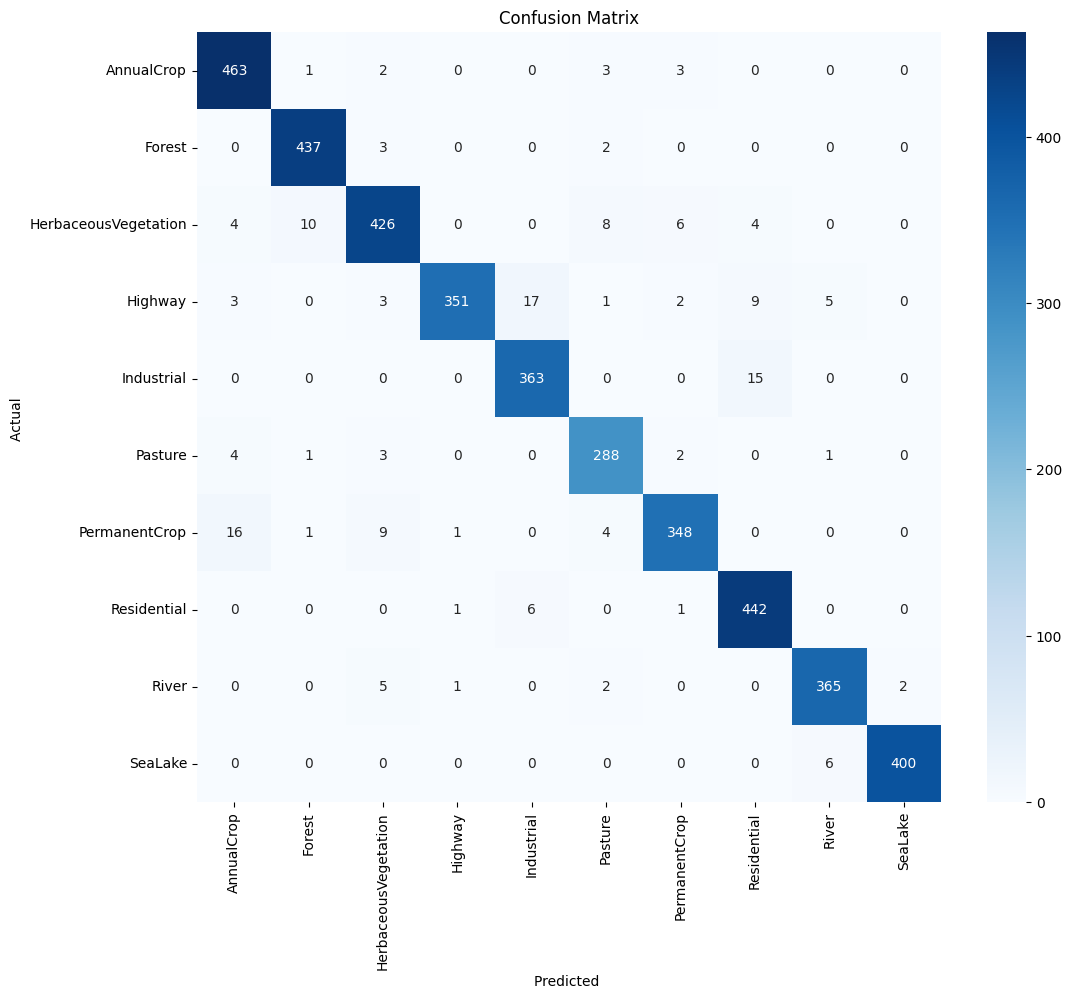

In [14]:
y_pred_list = []
y_true_list = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())
try:
    class_names = list(test_loader.dataset.subset.dataset.class_to_idx.keys())
except:
    class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 
                    'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 
                    'River', 'SeaLake']

print("\nClassification Report:")
print(classification_report(y_true_list, y_pred_list, target_names=class_names))

cm = confusion_matrix(y_true_list, y_pred_list)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted ')
plt.ylabel('Actual ')
plt.title('Confusion Matrix')
plt.show()

Evaluating: 100%|██████████| 127/127 [00:43<00:00,  2.91it/s]


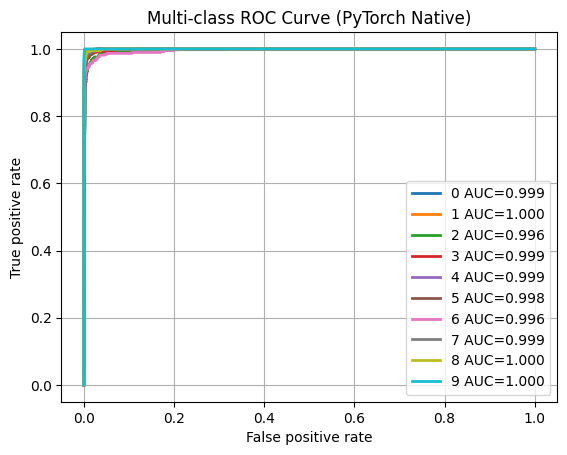

In [16]:
from torchmetrics.classification import MulticlassROC
y_probs_list = []
y_true_list = []   
model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        labels = labels.to(device)     
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        y_probs_list.append(probs.cpu())
        y_true_list.append(labels.cpu())
y_probs = torch.cat(y_probs_list)
y_true = torch.cat(y_true_list)
mc_roc = MulticlassROC(num_classes=10, thresholds=None)
mc_roc.update(y_probs, y_true)
fig, ax = mc_roc.plot(score=True) 
plt.title('Multi-class ROC Curve (PyTorch Native)')
plt.show()

In [17]:
def load_model():
    model = PrependResNet50(num_classes=10).to(device)
    model_path = r"D:\OneDrive - Computer and Information Technology (Menofia University)\Desktop\test\best_model.pth"

    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()
    return model

model = load_model()

In [20]:
CLASSES = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
    'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'
]

def predict_single_image(image_path, model, device):
    with rasterio.open(image_path) as src:
        image_np = src.read()
    image_tensor = torch.from_numpy(image_np).float()
    test_transform = MultiSpectralTestTransform(mean=MS_MEAN, std=MS_STD, resize_to=RESIZE_TO)
    image_tensor = test_transform(image_tensor)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)

    model.eval()
    with torch.no_grad(): 
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted_idx = torch.max(outputs, 1)
        confidence = probabilities[0][predicted_idx].item() * 100
        predicted_class = CLASSES[predicted_idx.item()]
    return predicted_class, confidence


test_image_path = r"D:\OneDrive - Computer and Information Technology (Menofia University)\Desktop\test\EuroSAT_MS\River\River_10.tif"

cls_name, conf = predict_single_image(test_image_path, model, device)
print(f"Prediction: {cls_name}")
print(f"Confidence: {conf:.2f}%")

Prediction: River
Confidence: 99.74%
